# Traffic Forecast — OOP Notebook (Full pipeline)
- Tác giả: Đức Anh
- Dữ liệu: `/content/data/Metro_Interstate_Traffic_Volume.csv`
- Mục tiêu: forecast `traffic_volume` (Task1: 2-step ahead; Task2: multi-step seq2seq)
- Nội dung: EDA, Feature Engineering (lags/rolling/Fourier/weather handling), Walk-forward splitting, Scaler on train only, Models: RNN/LSTM/BiLSTM/Customized, Trainer (AMP, grad clip, early stopping), metrics + plots


### Cài đặt các Thư viện

In [1]:
# Imports & basic setup
import os, time, joblib
from dataclasses import dataclass, asdict
from typing import List, Optional, Tuple, Dict
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# File path (use uploaded file)
DATA_PATH = '/content/Metro_Interstate_Traffic_Volume.csv'
print("Using data file:", DATA_PATH)

Using data file: /content/Metro_Interstate_Traffic_Volume.csv


### Cấu hình

In [2]:
@dataclass
class Config:
    data_path: str = DATA_PATH
    pred_col: str = 'traffic_volume'
    lookback: int = 48        # default, sẽ thử 48 / 168
    horizon_task1: int = 2
    horizon_task2: int = 5
    batch_size: int = 64
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    models_dir: str = '/content/data/models'
    processed_dir: str = '/content/data/processed'
    epochs: int = 12          # theo yêu cầu: train 12 epochs với EarlyStopping
    seed: int = 42

cfg = Config()
os.makedirs(cfg.models_dir, exist_ok=True)
os.makedirs(cfg.processed_dir, exist_ok=True)
np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)
if cfg.device == 'cuda': torch.cuda.manual_seed_all(cfg.seed)
print(asdict(cfg))

{'data_path': '/content/Metro_Interstate_Traffic_Volume.csv', 'pred_col': 'traffic_volume', 'lookback': 48, 'horizon_task1': 2, 'horizon_task2': 5, 'batch_size': 64, 'device': 'cuda', 'models_dir': '/content/data/models', 'processed_dir': '/content/data/processed', 'epochs': 12, 'seed': 42}


### DataProcessor class (bao gồm xử lý weather_main & weather_description

In [3]:
class DataProcessor:
    """
    Đọc, clean, xử lý weather_main + weather_description theo contribution của ToanNguyn,
    và tạo các biến thời gian cơ bản.
    """
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.scaler = None

    def read_raw(self) -> pd.DataFrame:
        df = pd.read_csv(self.cfg.data_path)
        return df

    def basic_clean(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        # date_time -> datetime
        df['date_time'] = pd.to_datetime(df['date_time'])
        df = df.sort_values('date_time').reset_index(drop=True)
        # create is_holiday (0/1) like your snippet
        if 'holiday' in df.columns:
            df['is_holiday'] = df['holiday'].notna().astype(int)
            df = df.drop(columns=['holiday'])
        # create basic time features (year/month/day/hour/dayofweek)
        df['year'] = df['date_time'].dt.year
        df['month'] = df['date_time'].dt.month
        df['day'] = df['date_time'].dt.day
        df['hour'] = df['date_time'].dt.hour
        df['day_of_week'] = df['date_time'].dt.dayofweek
        return df

    def weather_score_from_train(self, df: pd.DataFrame, target_series: pd.Series, train_mask) -> pd.DataFrame:
        """
        Tính weather_score = mean(traffic_volume) per weather_description trên tập train (như snippet),
        sau đó MinMax scale chỉ fit trên train.
        """
        df = df.copy()
        # combine to compute group means on train
        train_df = df[train_mask].copy()
        # create temporary combined to compute mean by weather_description
        combined = train_df.assign(traffic_volume=target_series[train_mask].values)
        weather_score = combined.groupby('weather_description')['traffic_volume'].mean()
        weather_score_map = weather_score.to_dict()
        # map to full df (NaN -> global mean)
        global_mean = combined['traffic_volume'].mean()
        df['weather_score'] = df['weather_description'].map(weather_score_map).fillna(global_mean)
        # Fit MinMaxScaler on train segment only (like snippet)
        scaler = MinMaxScaler()
        scaler.fit(df.loc[train_mask, ['weather_score']])
        df.loc[train_mask, ['weather_score']] = scaler.transform(df.loc[train_mask, ['weather_score']])
        df.loc[~train_mask, ['weather_score']] = scaler.transform(df.loc[~train_mask, ['weather_score']])
        self.weather_scaler = scaler
        return df

    def drop_raw_weather_and_datetime(self, df: pd.DataFrame) -> pd.DataFrame:
        # optionally keep weather_main encoded; drop raw columns if needed
        drop_cols = []
        for c in ['weather_description','date_time']:
            if c in df.columns:
                drop_cols.append(c)
        # keep weather_main for one-hot later if desired, else drop it
        # We'll keep weather_main and later one-hot top categories in FeatureEngineer
        # So here only drop date_time and weather_description
        if 'date_time' in drop_cols:
            df = df.drop(columns=['date_time'])
        if 'weather_description' in drop_cols:
            df = df.drop(columns=['weather_description'])
        return df

    def run_initial(self):
        df_raw = self.read_raw()
        df = self.basic_clean(df_raw)
        return df

# Usage:
dp = DataProcessor(cfg)
df0 = dp.run_initial()

### Feature Engineering

In [4]:
class FeatureEngineer:
    def __init__(self, cfg: Config, features_to_keep: Optional[List[str]] = None):
        self.cfg = cfg
        self.features_to_keep = features_to_keep

    def add_lags_rollings(self, df: pd.DataFrame, target_col: str) -> pd.DataFrame:
        df = df.copy()
        # Lag features (like snippet)
        df[f'{target_col}_lag1'] = df[target_col].shift(1)
        df[f'{target_col}_lag2'] = df[target_col].shift(2)
        df[f'{target_col}_lag24'] = df[target_col].shift(24)
        df[f'{target_col}_lag168'] = df[target_col].shift(168)
        # rolling windows
        for w in [3,6,24,168]:
            df[f'{target_col}_roll_mean_{w}'] = df[target_col].shift(1).rolling(window=w, min_periods=1).mean()
            df[f'{target_col}_roll_median_{w}'] = df[target_col].shift(1).rolling(window=w, min_periods=1).median()
            df[f'{target_col}_roll_std_{w}'] = df[target_col].shift(1).rolling(window=w, min_periods=1).std().fillna(0)
        return df

    def add_fourier(self, df: pd.DataFrame):
        df = df.copy()
        hour = df['hour'] + 0.0
        df['sin_24'] = np.sin(2*np.pi*hour/24)
        df['cos_24'] = np.cos(2*np.pi*hour/24)
        week_hour = df['day_of_week']*24 + df['hour']
        df['sin_168'] = np.sin(2*np.pi*week_hour/168)
        df['cos_168'] = np.cos(2*np.pi*week_hour/168)
        return df

    def encode_weather(self, df: pd.DataFrame, top_k: int = 8):
        df = df.copy()
        # One-hot top_k weather_main
        if 'weather_main' in df.columns:
            top_weather = df['weather_main'].value_counts().nlargest(top_k).index.tolist()
            for w in top_weather:
                col = f'weather_{w}'
                df[col] = (df['weather_main'] == w).astype(int)
            # drop original or keep? drop to avoid leakage
            df = df.drop(columns=['weather_main'])
        # is_holiday already created in DataProcessor
        return df

    def finalize(self, df: pd.DataFrame, target_col: str):
        # apply sequence: lags/rolling -> fourier -> weather encoding
        df = self.add_lags_rollings(df, target_col)
        df = self.add_fourier(df)
        df = self.encode_weather(df)
        # drop rows with NaN (due to lags)
        df = df.dropna().reset_index(drop=True)
        return df

# Usage:
# fe = FeatureEngineer(cfg)
# df_fe = fe.finalize(df_with_weather_score, 'traffic_volume')

### Run Processed Data

In [6]:
# 1) Prepare DataProcessor and initial DF
# Đã chạy ở trên rồi
# dp = DataProcessor(cfg)
# df0 = dp.run_initial()   # contains year/month/day/hour/day_of_week, original weather columns, etc.

# create a train mask by date like snippet: before 2018-01-01 -> train, >= 2018-01-01 -> test
train_mask = df0['date_time'] < "2018-01-01"
test_mask  = df0['date_time'] >= "2018-01-01"

# 2) Compute weather_score (using train target) like member's snippet
# Extract target series from original raw (we'll use column 'traffic_volume' from df0)
y_full = df0['traffic_volume'].copy()
df_ws = dp.weather_score_from_train(df0, y_full, train_mask)

# 3) Drop raw weather_description and date_time (we'll keep weather_main encoded later)
df_ws = dp.drop_raw_weather_and_datetime(df_ws)

# 4) Feature engineering
fe = FeatureEngineer(cfg)
df_fe = fe.finalize(df_ws, cfg.pred_col)
print("After feature engineering shape:", df_fe.shape)

# 5) Re-split into train/test using 'year' column as in snippet
# (note: after finalize we reset_index-> sequential index, but we preserved 'year' column)
train_mask_final = df_fe['year'] < 2018
test_mask_final  = df_fe['year'] >= 2018
df_train = df_fe[train_mask_final].copy().reset_index(drop=True)
df_test  = df_fe[test_mask_final].copy().reset_index(drop=True)
y_train  = df_train[cfg.pred_col].copy()
y_test   = df_test[cfg.pred_col].copy()
print("Train/test shapes:", df_train.shape, df_test.shape)

After feature engineering shape: (48036, 40)
Train/test shapes: (40087, 40) (7949, 40)


In [7]:
# Select features (all numeric except target? we'll include target as feature for lags etc.)
numeric_cols = df_fe.select_dtypes(include='number').columns.tolist()
# keep all numeric features; ensure target is in features
features = [c for c in numeric_cols if c != 'index']  # drop index if present
print("Total numeric features:", len(features))

# Fit scaler on train only
scaler = MinMaxScaler()
scaler.fit(df_train[features])
train_scaled = pd.DataFrame(scaler.transform(df_train[features]), columns=features)
test_scaled  = pd.DataFrame(scaler.transform(df_test[features]), columns=features)

joblib.dump(scaler, os.path.join(cfg.processed_dir, 'scaler_train.save'))
print("Scaler saved.")

# TimeSeries Dataset class (windowing)
class TimeSeriesDataset(Dataset):
    def __init__(self, df_scaled: pd.DataFrame, features: List[str], lookback: int, horizon: int, pred_col: str):
        self.X = df_scaled[features].values.astype(np.float32)
        self.lookback = lookback
        self.horizon = horizon
        self.pred_idx = features.index(pred_col)
        self.length = len(self.X) - lookback - horizon + 1
    def __len__(self): return max(0, self.length)
    def __getitem__(self, idx):
        s = idx
        x = self.X[s:s+self.lookback]
        y = self.X[s+self.lookback:s+self.lookback+self.horizon, self.pred_idx]
        return torch.from_numpy(x), torch.from_numpy(y)

# Create datasets and dataloaders
LOOKBACK = cfg.lookback
H1 = cfg.horizon_task1

train_ds = TimeSeriesDataset(train_scaled, features, LOOKBACK, H1, cfg.pred_col)
test_ds  = TimeSeriesDataset(test_scaled, features, LOOKBACK, H1, cfg.pred_col)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False)

print("Samples train/test:", len(train_ds), len(test_ds))

Total numeric features: 40
Scaler saved.
Samples train/test: 40038 7900


### Mô hình

In [8]:
# Model definitions
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight)

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, horizon=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden, num_layers=num_layers, batch_first=True)
        self.head = nn.Sequential(nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Linear(hidden//2, horizon))
        self.apply(init_weights)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.head(out[:, -1, :])

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, horizon=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=num_layers, batch_first=True)
        self.head = nn.Sequential(nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Linear(hidden//2, horizon))
        self.apply(init_weights)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1, :])

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, horizon=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=num_layers, batch_first=True, bidirectional=True)
        # hidden*2 due to bidirectional
        self.head = nn.Sequential(nn.Linear(hidden*2, hidden), nn.ReLU(), nn.Linear(hidden, horizon))
        self.apply(init_weights)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1, :])

class CustomizedLSTM(nn.Module):
    def __init__(self, input_dim, hidden=128, num_layers=1, horizon=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=num_layers, batch_first=True)
        # attention: single-head score
        self.attn = nn.Linear(hidden, 1)
        self.res_fc = nn.Linear(input_dim, hidden)
        self.head = nn.Sequential(nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Linear(hidden//2, horizon))
        self.apply(init_weights)
    def forward(self, x):
        out, _ = self.lstm(x)
        scores = torch.softmax(self.attn(out).squeeze(-1), dim=1).unsqueeze(-1)
        context = (out * scores).sum(dim=1)
        residual = self.res_fc(x[:, -1, :])
        return self.head(context + residual)

In [10]:
class Trainer:
    def __init__(self, cfg: Config, features: List[str], scaler):
        self.cfg = cfg
        self.device = torch.device(cfg.device)
        self.features = features
        self.scaler = scaler

    def train(self, model: nn.Module, train_loader: DataLoader, val_loader: Optional[DataLoader]=None,
              task=1, horizon=1, epochs=12, lr=1e-3, grad_clip=1.0, use_amp=True, patience=3, save_name='model'):
        model = model.to(self.device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=2, factor=0.5)
        scaler_amp = torch.cuda.amp.GradScaler(enabled=(use_amp and self.device.type=='cuda'))
        best_val = float('inf'); best_state=None; epochs_no_improve = 0
        for ep in range(1, epochs+1):
            model.train(); train_losses=[]
            for xb, yb in train_loader:
                xb = xb.to(self.device); yb = yb.to(self.device)
                opt.zero_grad()
                with torch.cuda.amp.autocast(enabled=use_amp and self.device.type=='cuda'):
                    if task==1:
                        pred = model(xb)
                    else:
                        pred = model(xb)  # for seq2seq different interface
                    loss = nn.MSELoss()(pred, yb)
                scaler_amp.scale(loss).backward()
                scaler_amp.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
                scaler_amp.step(opt); scaler_amp.update()
                train_losses.append(float(loss.detach().cpu().numpy()))
            # validation
            if val_loader is not None:
                model.eval(); val_losses=[]
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb = xb.to(self.device); yb = yb.to(self.device)
                        if task==1:
                            pred = model(xb)
                        else:
                            pred = model(xb)
                        val_losses.append(float(nn.MSELoss()(pred, yb).cpu().numpy()))
                tr_loss = np.mean(train_losses); val_loss = np.mean(val_losses)
                scheduler.step(val_loss)
                if val_loss < best_val:
                    best_val = val_loss; best_state = model.state_dict(); epochs_no_improve = 0
                    torch.save(best_state, os.path.join(self.cfg.models_dir, f'{save_name}.pth'))
                else:
                    epochs_no_improve += 1
                print(f'Epoch {ep}/{epochs} train={tr_loss:.6f} val={val_loss:.6f}')
                if epochs_no_improve >= patience:
                    print("Early stopping triggered (patience).")
                    break
            else:
                tr_loss = np.mean(train_losses)
                print(f'Epoch {ep}/{epochs} train={tr_loss:.6f}')
        if best_state is not None:
            model.load_state_dict(best_state)
        return model

    def evaluate(self, model: nn.Module, loader: DataLoader, horizon: int):
        model = model.to(self.device); model.eval()
        Ys=[]; Ps=[]
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(self.device)
                p = model(xb).cpu().numpy()
                Ys.append(yb.numpy()); Ps.append(p)
        Y = np.vstack(Ys); P = np.vstack(Ps)
        # inverse scale using stored scaler
        def inv_scaled(arr):
            n, h = arr.shape
            mats = np.zeros((n, len(self.features)))
            outs = []
            for i in range(h):
                mats[:, self.features.index(cfg.pred_col)] = arr[:, i]
                outs.append(self.scaler.inverse_transform(mats)[:, self.features.index(cfg.pred_col)])
            return np.stack(outs, axis=1)
        Y_inv = inv_scaled(Y); P_inv = inv_scaled(P)
        rows=[]
        for i in range(horizon):
            yt = Y_inv[:, i]; yp = P_inv[:, i]
            mae = mean_absolute_error(yt, yp); rmse = np.sqrt(mean_squared_error(yt, yp))
            r2 = r2_score(yt, yp); denom = np.sum((yt-np.mean(yt))**2)
            nse = 1 - np.sum((yt-yp)**2)/denom if denom != 0 else np.nan
            rows.append({'horizon': i+1, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'NSE': nse})
        return pd.DataFrame(rows), Y_inv, P_inv

\n=== Training SimpleRNN ===


/tmp/ipython-input-1111403115.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=(use_amp and self.device.type=='cuda'))
/tmp/ipython-input-1111403115.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and self.device.type=='cuda'):


Epoch 1/12 train=0.013428 val=0.006078
Epoch 2/12 train=0.007876 val=0.005598
Epoch 3/12 train=0.007036 val=0.004735
Epoch 4/12 train=0.006671 val=0.004227
Epoch 5/12 train=0.006435 val=0.005126
Epoch 6/12 train=0.006165 val=0.003927
Epoch 7/12 train=0.006007 val=0.003882
Epoch 8/12 train=0.005907 val=0.003665
Epoch 9/12 train=0.005828 val=0.003530
Epoch 10/12 train=0.005754 val=0.003680
Epoch 11/12 train=0.005631 val=0.003641
Epoch 12/12 train=0.005647 val=0.003431
Test metrics for SimpleRNN :\n    horizon         MAE        RMSE        R2       NSE
0        1  255.409268  371.689210  0.964535  0.964535
1        2  323.180897  464.791272  0.944550  0.944550


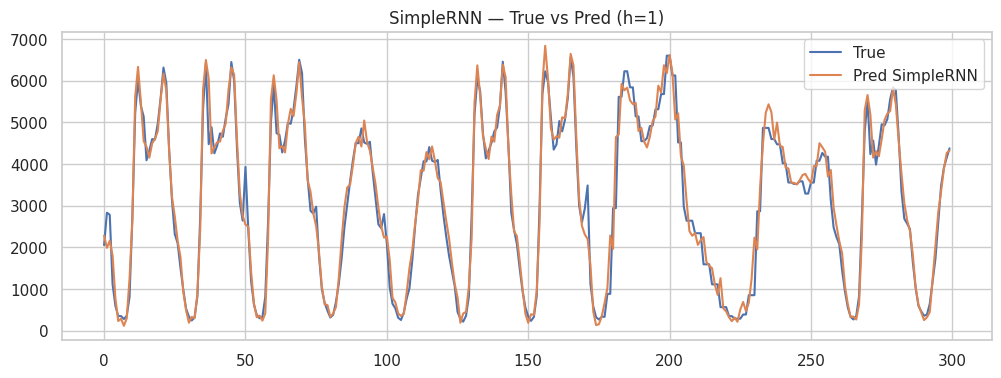

\n=== Training SimpleLSTM ===


/tmp/ipython-input-1111403115.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=(use_amp and self.device.type=='cuda'))
/tmp/ipython-input-1111403115.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and self.device.type=='cuda'):


Epoch 1/12 train=0.016966 val=0.006948
Epoch 2/12 train=0.008556 val=0.005464
Epoch 3/12 train=0.007218 val=0.004599
Epoch 4/12 train=0.006512 val=0.003909
Epoch 5/12 train=0.006067 val=0.003691
Epoch 6/12 train=0.005783 val=0.003971
Epoch 7/12 train=0.005666 val=0.003751
Epoch 8/12 train=0.005420 val=0.003569
Epoch 9/12 train=0.005318 val=0.003648
Epoch 10/12 train=0.005109 val=0.003204
Epoch 11/12 train=0.005088 val=0.003339
Epoch 12/12 train=0.004932 val=0.003446
Test metrics for SimpleLSTM :\n    horizon         MAE        RMSE        R2       NSE
0        1  245.492838  366.587037  0.965502  0.965502
1        2  306.504262  461.455275  0.945343  0.945343


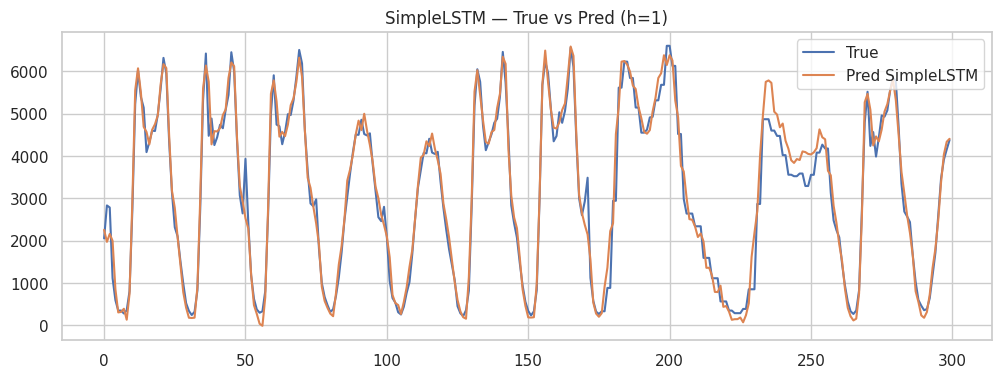

\n=== Training BiLSTM ===


/tmp/ipython-input-1111403115.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=(use_amp and self.device.type=='cuda'))
/tmp/ipython-input-1111403115.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and self.device.type=='cuda'):


Epoch 1/12 train=0.017261 val=0.006975
Epoch 2/12 train=0.008835 val=0.005061
Epoch 3/12 train=0.007345 val=0.004606
Epoch 4/12 train=0.006662 val=0.004378
Epoch 5/12 train=0.006179 val=0.004457
Epoch 6/12 train=0.006002 val=0.003931
Epoch 7/12 train=0.005754 val=0.004649
Epoch 8/12 train=0.005626 val=0.003844
Epoch 9/12 train=0.005397 val=0.003856
Epoch 10/12 train=0.005380 val=0.004010
Epoch 11/12 train=0.005184 val=0.003693
Epoch 12/12 train=0.005104 val=0.003472
Test metrics for BiLSTM :\n    horizon         MAE        RMSE        R2       NSE
0        1  279.458010  383.912537  0.962164  0.962164
1        2  342.120434  480.355161  0.940774  0.940774


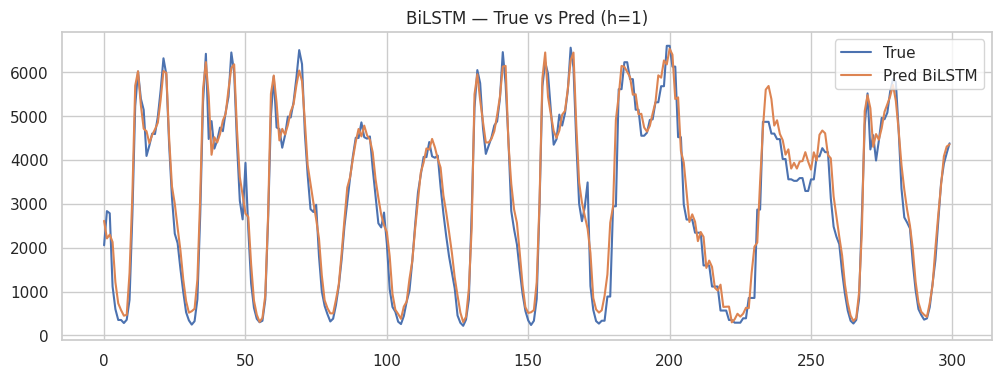

\n=== Training CustomizedLSTM ===


/tmp/ipython-input-1111403115.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=(use_amp and self.device.type=='cuda'))
/tmp/ipython-input-1111403115.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and self.device.type=='cuda'):


Epoch 1/12 train=0.014493 val=0.007259
Epoch 2/12 train=0.009361 val=0.005766
Epoch 3/12 train=0.008091 val=0.005124
Epoch 4/12 train=0.007208 val=0.005176
Epoch 5/12 train=0.006715 val=0.004700
Epoch 6/12 train=0.006497 val=0.006662
Epoch 7/12 train=0.006532 val=0.004733
Epoch 8/12 train=0.006210 val=0.004633
Epoch 9/12 train=0.006165 val=0.004244
Epoch 10/12 train=0.006069 val=0.005294
Epoch 11/12 train=0.006025 val=0.004173
Epoch 12/12 train=0.005911 val=0.004585
Test metrics for CustomizedLSTM :\n    horizon         MAE        RMSE        R2       NSE
0        1  292.308336  410.921905  0.956653  0.956653
1        2  374.861926  526.657643  0.928806  0.928806


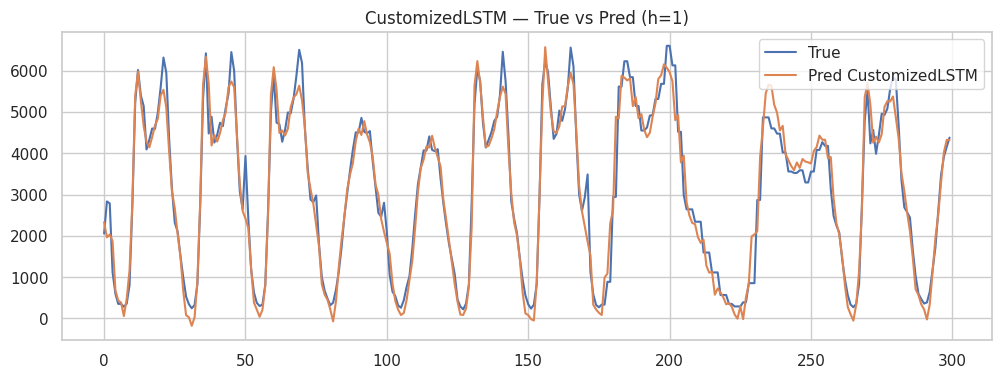

In [11]:
trainer = Trainer(cfg, features, scaler)

# create validation split from train_scaled (simple time-split)
n_train = len(train_scaled)
val_ratio = 0.15
val_len = int(n_train * val_ratio)
train_part = train_scaled.iloc[:-val_len].reset_index(drop=True)
val_part   = train_scaled.iloc[-val_len:].reset_index(drop=True)

tr_ds = TimeSeriesDataset(train_part, features, LOOKBACK, H1, cfg.pred_col)
va_ds = TimeSeriesDataset(val_part, features, LOOKBACK, H1, cfg.pred_col)
te_ds = TimeSeriesDataset(test_scaled, features, LOOKBACK, H1, cfg.pred_col)

tr_loader = DataLoader(tr_ds, batch_size=cfg.batch_size, shuffle=True)
va_loader = DataLoader(va_ds, batch_size=cfg.batch_size, shuffle=False)
te_loader = DataLoader(te_ds, batch_size=cfg.batch_size, shuffle=False)

# Models to train
models = {
    'SimpleRNN': SimpleRNN(len(features), hidden=128, num_layers=1, horizon=H1),
    'SimpleLSTM': SimpleLSTM(len(features), hidden=128, num_layers=1, horizon=H1),
    'BiLSTM': BiLSTM(len(features), hidden=96, num_layers=1, horizon=H1),
    'CustomizedLSTM': CustomizedLSTM(len(features), hidden=128, num_layers=1, horizon=H1)
}

results = {}
for name, model in models.items():
    print('\\n=== Training', name, '===')
    trained = trainer.train(model, tr_loader, va_loader, task=1, horizon=H1, epochs=cfg.epochs, lr=1e-3, grad_clip=1.0, use_amp=False, patience=3, save_name=name)
    metrics, Yinv, Pinv = trainer.evaluate(trained, te_loader, horizon=H1)
    print('Test metrics for', name, ':\\n', metrics)
    # plot first 300 samples true vs pred (h=1)
    nplot = min(300, Yinv.shape[0])
    plt.figure(figsize=(12,4))
    plt.plot(Yinv[:nplot,0], label='True')
    plt.plot(Pinv[:nplot,0], label=f'Pred {name}')
    plt.title(f'{name} — True vs Pred (h=1)'); plt.legend(); plt.show()
    results[name] = {'model': trained, 'metrics': metrics, 'Y': Yinv, 'P': Pinv}
    # save model path already saved in trainer.train

,model,MAE_h1,RMSE_h1,R2_h1
1,SimpleLSTM,245.492838,366.587037,0.965502
0,SimpleRNN,255.409268,371.689210,0.964535
2,BiLSTM,279.458010,383.912537,0.962164
3,CustomizedLSTM,292.308336,410.921905,0.956653


Best model: SimpleLSTM
            mean         std
hour                        
0     -28.349814  205.296989
1      51.238782  134.688521
2     118.585348  107.468296
3      -2.347182  249.843380
4    -234.702649  498.567671
5    -320.131693  756.986682
6      -5.924992  440.676879
7      44.031381  381.082048
8     -31.501388  386.643800
9     -14.986758  298.338046
10   -173.257230  249.002152
11     -3.384692  204.488544
12     26.765223  219.846397
13   -189.553495  244.096526
14   -164.909419  217.982602
15   -133.358619  300.491396
16     69.280826  325.320876
17    -53.905864  414.289429
18     97.322996  392.953668
19     20.397305  263.493921
20     14.956607  211.878527
21    125.916390  321.549328
22    111.456750  380.287710
23     75.443912  396.352323


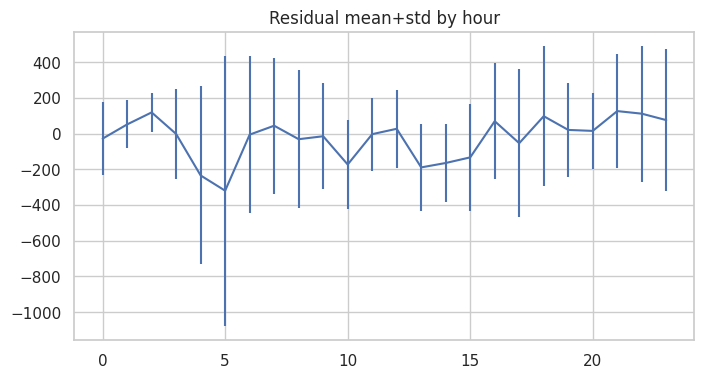

In [13]:
# Summarize metrics
summary = []
for name in results:
    dfm = results[name]['metrics']
    summary.append({'model': name, 'MAE_h1': dfm.loc[0,'MAE'], 'RMSE_h1': dfm.loc[0,'RMSE'], 'R2_h1': dfm.loc[0,'R2']})
summary_df = pd.DataFrame(summary).sort_values('RMSE_h1')
display(summary_df)

# residual by hour for best model (lowest RMSE)
best = summary_df.iloc[0]['model']
print("Best model:", best)
Ybest = results[best]['Y'][:,0]
Pbest = results[best]['P'][:,0]

# The original df_test has the 'hour' column.
# Ybest and Pbest correspond to the predictions starting from the (LOOKBACK)-th sample
# in the test_scaled dataset. The length of Ybest is len(test_ds).
# So, the relevant hours are from df_test for the indices corresponding to these predictions.
# The predictions correspond to the target values from index LOOKBACK to LOOKBACK + len(test_ds) - 1 of df_test.
hours_for_residuals = df_test.iloc[LOOKBACK : LOOKBACK + len(Ybest)]['hour']

res_ser = pd.Series(Ybest - Pbest, index=hours_for_residuals)
grp = res_ser.groupby(res_ser.index).agg(['mean','std']) # Group by the hour values directly
print(grp)
plt.figure(figsize=(8,4)); plt.errorbar(grp.index, grp['mean'], yerr=grp['std']); plt.title('Residual mean+std by hour'); plt.show()